# Graph & Routing

This notebook contains the code for building our network graph and routing algorithm.

In [1]:
# necessary imports
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, MultiLineString, Point
from collections import defaultdict

import random
import math
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Union

import folium

import matplotlib.pyplot as plt
from tueplots import bundles, figsizes
from tueplots.constants.color import palettes

# set project root
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# module imports
from src.routing_graph import (
    GraphBuildConfig,
    RiskConfig,
    RoutingGraphArtifacts,
    build_routing_graph,
    build_graph_with_risk,
    verify_graph_sanity,
    NodeKey,
)
from src.routing_algorithm import (
    nearest_graph_node,
    route_stats,
    shortest_path_by,
    constrained_min_risk_route,
    run_one_od_routing,
    path_to_multiline_latlon,
)

DATA_DIR = Path("..") / "data" / "panel"


The next cell loads the data frames that were constructed through the merging procedure executed in `01_data_preparation.ipynb` and derives longitude and latitude data from the the geometry column.

In [2]:
acc_node_df = gpd.read_parquet(DATA_DIR / "acc_node.parquet")
segments_df = gpd.read_parquet(DATA_DIR / "segments_with_risk.parquet")
junction_df = gpd.read_parquet(DATA_DIR / "junctions_with_risk.parquet")

# Ensure expected CRS for folium (lat/lon)
junction_df = junction_df.to_crs(epsg=4326)
acc_node_df = acc_node_df.to_crs(epsg=4326)
segments_df = segments_df.to_crs(epsg=4326)

# Create longitude and latitude columns from geometry
if "longitude" not in junction_df.columns:
    junction_df["longitude"] = junction_df.geometry.x
if "latitude" not in junction_df.columns:
    junction_df["latitude"] = junction_df.geometry.y

if "longitude" not in acc_node_df.columns:
    acc_node_df["longitude"] = acc_node_df.geometry.x
if "latitude" not in acc_node_df.columns:
    acc_node_df["latitude"] = acc_node_df.geometry.y


acc_node_df


,acc_id,year,month,geometry,light_condition,accident_type,accident_kind,injury_severity,index_node,node_id,dist_node,has_crossing,longitude,latitude
0,20226,2021,4,POINT (13.48861 52.46449),0,5,1,2,NaN,NaN,NaN,False,13.488608,52.464495
1,3881,2019,9,POINT (13.60631 52.45275),1,2,5,3,NaN,NaN,NaN,False,13.606309,52.452751
2,1750,2019,5,POINT (13.3133 52.57682),0,2,5,3,NaN,NaN,NaN,False,13.313300,52.576824
3,1922,2019,5,POINT (13.68352 52.37053),0,1,0,1,NaN,NaN,NaN,False,13.683520,52.370531
4,13090,2022,8,POINT (13.45826 52.48577),0,1,0,3,1482.0,1518.0,9.360363,True,13.458259,52.485774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15391,3319,2019,8,POINT (13.21397 52.53838),0,2,5,3,NaN,NaN,NaN,False,13.213969,52.538384
15392,6510,2020,4,POINT (13.32488 52.50253),2,1,0,3,NaN,NaN,NaN,False,13.324880,52.502526
15393,22519,2021,9,POINT (13.45723 52.56107),0,2,5,3,NaN,NaN,NaN,False,13.457235,52.561067
15394,21785,2021,7,POINT (13.55801 52.45571),0,2,5,3,1790.0,1852.0,15.145493,True,13.558009,52.455714


## Prepare spatial data

The following cell constructs a crossings GeoDataFrame with one geometry per `node_id`, derives longitude and latitude coordinates from segment geometries, and creates a coordinate-to-segment mapping for efficient spatial lookup.

In [3]:
# one geometry per node_id
crossings_gdf = (
    junction_df[["node_id", "geometry"]]
    .dropna(subset=["node_id", "geometry"])
    .drop_duplicates(subset=["node_id"])
    .copy()
)

crossings_gdf = gpd.GeoDataFrame(
    crossings_gdf,
    geometry="geometry",
    crs=junction_df.crs,
)

rep = segments_df.geometry.representative_point()
segments_df["longitude"] = rep.x
segments_df["latitude"] = rep.y

coords_to_segments = defaultdict(set)

for name, geom in zip(segments_df["counter_name"], segments_df.geometry):
    for lon, lat in geom.coords:
        coords_to_segments[(lat, lon)].add(name)


## Run routing for one OD pair

In [4]:
# Example origin-destination routing for Berlin
metric_epsg = 32633
ETA = 1.0
EPS = 0.10

# These are Berlin coordinates (lon, lat)
origin_lonlat = (13.3777, 52.5163)    # Brandenburg Gate area
dest_lonlat = (13.4541, 52.5110)      # East Berlin

result_berlin = run_one_od_routing(
    segments_panel_gdf=segments_df,
    crossings_gdf=crossings_gdf,
    junction_panel_gdf=junction_df,
    origin_lonlat=origin_lonlat,
    dest_lonlat=dest_lonlat,
    eps=EPS,
    eta=ETA,
)

if result_berlin.get("status") == "disconnected":
    raise RuntimeError("OD pair disconnected in the routing graph.")

G = result_berlin.get("graph", None)
if G is None:
    # fallback 
    artifacts = build_graph_with_risk(
        segments_gdf=segments_df,
        crossings_gdf=crossings_gdf,
        junction_gdf=junction_df,
        risk_cfg=RiskConfig(eta=ETA),
    )

    G = artifacts.G

# Shortest path geometry: choose_by length
shortest_geom = path_to_multiline_latlon(
    G, result_berlin["shortest_length_path"], metric_epsg=metric_epsg, choose_by="length_m"
)

# Safe path geometry: choose_by risk_total
safe_geom = path_to_multiline_latlon(
    G, result_berlin["constrained_min_risk_path"], metric_epsg=metric_epsg, choose_by="risk_total"
)


## Run routing over many OD pairs

In [5]:
# Extensive evaluation loop over MANY OD pairs

def _sample_reachable_od_pairs(
    G: nx.Graph,
    n_pairs: int,
    *,
    seed: int = 7,
    min_euclid_m: float = 1500.0,
    max_tries: int = 200000,
) -> list[tuple[NodeKey, NodeKey]]:
    """
    Samples OD pairs as graph nodes ensuring:
      - O != D
      - straight-line distance >= min_euclid_m
      - O and D are connected (same component) in the undirected sense
    """
    rng = random.Random(seed)
    nodes = list(G.nodes())
    if len(nodes) < 2:
        return []

    comp_map = {}
    for cid, comp in enumerate(nx.connected_components(G.to_undirected())):
        for n in comp:
            comp_map[n] = cid

    pairs: list[tuple[NodeKey, NodeKey]] = []
    tries = 0
    while len(pairs) < n_pairs and tries < max_tries:
        tries += 1
        a = rng.choice(nodes)
        b = rng.choice(nodes)
        if a == b:
            continue
        if comp_map.get(a) != comp_map.get(b):
            continue

        dx = float(a[0] - b[0])
        dy = float(a[1] - b[1])
        if math.sqrt(dx * dx + dy * dy) < min_euclid_m:
            continue

        pairs.append((a, b))

    return pairs


def evaluate_many_od_pairs(
    *,
    segments_panel_gdf: gpd.GeoDataFrame,
    crossings_gdf: gpd.GeoDataFrame,
    junction_panel_gdf: gpd.GeoDataFrame,
    n_pairs: int = 200,
    eps: float = 0.10,
    eta: float = 1.0,
    metric_epsg: int = 32633,
    seed: int = 7,
    min_euclid_m: float = 1500.0,
) -> pd.DataFrame:
    """
    Builds month graph once, samples many reachable OD pairs on the graph,
    and evaluates:
      - shortest-by-length (P_dist)
      - optional shortest-by-cost (mixed objective)
      - constrained min-risk (P_safe) minimizing risk_total under length constraint

    Returns a DataFrame with per-OD statistics + metadata.
    """
    artifacts = build_graph_with_risk(
        segments_panel_gdf,
        crossings_gdf=crossings_gdf,
        junction_panel_gdf=junction_panel_gdf,
        graph_cfg=GraphBuildConfig(metric_epsg=metric_epsg),
        risk_cfg=RiskConfig(eta=eta),
        node_snap_m=20.0,
    )

    sanity = verify_graph_sanity(
        artifacts,
        expect_junction_penalties=(eta != 0.0),
    )
    G = artifacts.G

    od_pairs = _sample_reachable_od_pairs(G, n_pairs, seed=seed, min_euclid_m=min_euclid_m)
    if len(od_pairs) == 0:
        raise ValueError("Could not sample any reachable OD pairs. Check graph connectivity / size.")

    rows = []
    n_skipped = 0

    for i, (src, dst) in enumerate(od_pairs):
        # 1) Shortest length (P_dist)
        p_len = shortest_path_by(G, src, dst, weight="length_m")
        if p_len is None:
            n_skipped += 1
            continue
        st_len = route_stats(G, p_len, choose_by="length_m")
        shortest_len = float(st_len["length_m"])
        max_len = (1.0 + eps) * shortest_len

        
        # 2) Constrained min-risk minimizing risk_total
        p_safe = constrained_min_risk_route(
            G,
            src,
            dst,
            eps=eps,
            length_attr="length_m",
            risk_attr="risk_total",
        )
        if p_safe is None:
            n_skipped += 1
            continue
        st_safe = route_stats(G, p_safe, choose_by="risk_total")

        # Route-level risk in Methods is R(P) = sum risk_total
        R_len = float(st_len["risk_total_sum"])
        R_safe = float(st_safe["risk_total_sum"])

        crashes_expected_dist = R_len
        crashes_expected_safe = R_safe
        crashes_avoided = R_len - R_safe

        row = {
            "pair_idx": i,
            "src_x": float(src[0]),
            "src_y": float(src[1]),
            "dst_x": float(dst[0]),
            "dst_y": float(dst[1]),

            "shortest_len_m": shortest_len,
            "shortest_risk_total_sum": R_len,

            "safe_len_m": float(st_safe["length_m"]),
            "safe_risk_total_sum": R_safe,

            "len_constraint_max_m": float(max_len),
            "safe_feasible": bool(float(st_safe["length_m"]) <= max_len + 1e-6),

            "crashes_expected_dist": crashes_expected_dist,
            "crashes_expected_safe": crashes_expected_safe,
            "crashes_avoided": crashes_avoided,
        }

        
        rows.append(row)

    df = pd.DataFrame(rows)

    # Trade-offs relative to shortest-distance route
    df["delta_L"] = (df["safe_len_m"] - df["shortest_len_m"]) / df["shortest_len_m"]
    df["delta_R"] = (df["shortest_risk_total_sum"] - df["safe_risk_total_sum"]) / df["shortest_risk_total_sum"].replace(0, np.nan)

    
    # Metadata for reproducibility
    df.attrs["graph_sanity"] = sanity
    df.attrs["notes"] = artifacts.notes
    df.attrs["eps"] = eps
    df.attrs["eta"] = eta
    df.attrs["seed"] = seed
    df.attrs["min_euclid_m"] = min_euclid_m
    df.attrs["n_pairs_requested"] = n_pairs
    df.attrs["n_pairs_sampled"] = len(od_pairs)
    df.attrs["n_pairs_used"] = len(df)
    df.attrs["n_pairs_skipped"] = n_skipped

    return df


# Example usage:
eval_df = evaluate_many_od_pairs(
    segments_panel_gdf=segments_df,
    crossings_gdf=crossings_gdf,
    junction_panel_gdf=junction_df,
    n_pairs=300,
    eps=0.10,
    eta=1.0,             
    seed=7,
    min_euclid_m=2000.0,
)
print(eval_df.attrs["graph_sanity"])
print(eval_df[["delta_L", "delta_R"]].describe())


{'n_nodes': 3048, 'n_edges': 4335, 'seg_risk_min': 1.9705778676989382e-06, 'seg_risk_median': 6.018735379395284e-05, 'seg_risk_max': 0.0030569636852363657, 'risk_total_median': 0.00012037470758790568, 'risk_total_max': 0.0031171510390303183, 'length_median': 372.42039723707796, 'node_penalty_nonzero_share': 0.9983852364475202, 'graph_node_ids_attached': 2862, 'notes': 'Attached node_id to 2862/3048 graph nodes (snap<= 20.0m). Risk objective uses eta=1.0 for junction penalty weighting.'}
          delta_L     delta_R
count  300.000000  300.000000
mean     0.025381    0.170689
std      0.026315    0.146492
min      0.000000    0.000000
25%      0.001958    0.027088
50%      0.017649    0.148559
75%      0.039929    0.268648
max      0.099884    0.564663


## Loop routing over all months

Following [Natera Orozco et al. (2020)](https://doi.org/10.1098/rsos.201130), we evaluate our routing algorithm using `N_PAIRS = 1000` randomly selected origin-destination pairs.

### Loop with different $\eta$ and $\varepsilon$.

In [ ]:
results = []

ETA_LIST = [0.0, 0.5, 1.0]
EPS_LIST = [0.05, 0.10, 0.20]
N_PAIRS = 1000

for ETA in ETA_LIST:
    for EPS in EPS_LIST:
        try:
            eval_df = evaluate_many_od_pairs(
                segments_panel_gdf=segments_df,
                crossings_gdf=crossings_gdf,
                junction_panel_gdf=junction_df,
                n_pairs=N_PAIRS,
                eps=EPS,
                eta=ETA,
            )
        except ValueError as e:
            print(f"[skip] eta={ETA}, eps={EPS}: {e}")
            continue

        if eval_df is None or len(eval_df) == 0:
            print(f"[skip] eta={ETA}, eps={EPS}: empty evaluation frame")
            continue

        eval_df = eval_df.copy()
        eval_df["eta"] = ETA
        eval_df["eps"] = EPS
        eval_df["n_pairs_target"] = N_PAIRS
        results.append(eval_df)

if not results:
    raise RuntimeError("No valid OD-pair evaluations.")

all_eval = pd.concat(results, ignore_index=True)


In [7]:
all_eval.attrs if hasattr(all_eval, "attrs") else "attrs lost on concat"

{}

In [ ]:
def q(x, p):
    return float(np.nanquantile(x, p))

summary = (
    all_eval
    .groupby(["eta", "eps"], as_index=False)
    .apply(lambda g: pd.Series({
        "n_pairs": int(len(g)),
        "feasible_share": float(np.mean(g["safe_feasible"].astype(bool))),
        "median_delta_L": float(np.nanmedian(g["delta_L"])),
        "iqr_delta_L": float(q(g["delta_L"], 0.75) - q(g["delta_L"], 0.25)),
        "median_delta_R": float(np.nanmedian(g["delta_R"])),
        "iqr_delta_R": float(q(g["delta_R"], 0.75) - q(g["delta_R"], 0.25)),
        "share_delta_R_pos": float(np.mean(g["delta_R"] > 0)),
        "median_shortest_len_m": float(np.nanmedian(g["shortest_len_m"])),
        "median_safe_len_m": float(np.nanmedian(g["safe_len_m"])),
        "median_shortest_risk": float(np.nanmedian(g["shortest_risk_total_sum"])),
        "median_safe_risk": float(np.nanmedian(g["safe_risk_total_sum"])),
        "median_crashes_expected_dist": float(np.nanmedian(g["crashes_expected_dist"])),
        "median_crashes_expected_safe": float(np.nanmedian(g["crashes_expected_safe"])),
        "median_crashes_avoided": float(np.nanmedian(g["crashes_avoided"])),
    }))
    .reset_index(drop=True)
)

summary_fmt = summary.copy()
summary_fmt["feasible_share"] = (100 * summary_fmt["feasible_share"]).round(1)
summary_fmt["share_delta_R_pos"] = (100 * summary_fmt["share_delta_R_pos"]).round(1)

for c in ["median_delta_L", "iqr_delta_L", "median_delta_R", "iqr_delta_R"]:
    summary_fmt[c] = summary_fmt[c].round(4)

for c in ["median_shortest_len_m", "median_safe_len_m"]:
    summary_fmt[c] = summary_fmt[c].round(1)

for c in ["median_shortest_risk", "median_safe_risk"]:
    summary_fmt[c] = summary_fmt[c].round(3)

# for c in ["median_crashes_expected_dist", "median_crashes_expected_safe", 
#           "median_crashes_avoided"]:
#     summary_fmt[c] = summary_fmt[c].round(3)

trips_scale = 100_000
scaled_dist = summary_fmt["median_crashes_expected_dist"] * trips_scale
scaled_safe = summary_fmt["median_crashes_expected_safe"] * trips_scale

for c in ["median_crashes_expected_dist", "median_crashes_expected_safe", "median_crashes_avoided"]:
    summary_fmt[c] = (summary_fmt[c] * trips_scale).round(1)

summary_fmt = summary_fmt.sort_values(["eps", "eta"]).reset_index(drop=True)

summary_fmt


/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_15747/3260724952.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,eta,eps,n_pairs,feasible_share,median_delta_L,iqr_delta_L,median_delta_R,iqr_delta_R,share_delta_R_pos,median_shortest_len_m,median_safe_len_m,median_shortest_risk,median_safe_risk,median_crashes_expected_dist,median_crashes_expected_safe,median_crashes_avoided,frac_expected_crashes_avoided
0,0.0,0.05,1000.0,100.0,0.0069,0.0205,0.1348,0.2909,74.9,14881.5,15107.4,0.003,0.002,270.1,219.5,32.0,0.187
1,0.5,0.05,1000.0,100.0,0.0069,0.0202,0.1162,0.2387,77.3,14881.5,15091.4,0.004,0.003,364.8,308.3,35.8,0.155
2,1.0,0.05,1000.0,100.0,0.0070,0.0219,0.1012,0.2100,76.7,14881.5,15103.4,0.005,0.004,458.3,396.2,38.7,0.136
3,0.0,0.10,1000.0,100.0,0.0130,0.0314,0.1818,0.2993,81.6,14881.5,15282.5,0.003,0.002,270.1,205.4,43.8,0.239
4,0.5,0.10,1000.0,100.0,0.0128,0.0314,0.1553,0.2489,83.6,14881.5,15368.7,0.004,0.003,364.8,298.3,50.5,0.182
5,1.0,0.10,1000.0,100.0,0.0154,0.0372,0.1466,0.2403,84.1,14881.5,15356.0,0.005,0.004,458.3,378.7,60.6,0.174
6,0.0,0.20,1000.0,100.0,0.0338,0.1074,0.2441,0.3022,88.1,14881.5,15865.9,0.003,0.002,270.1,190.2,61.9,0.296
7,0.5,0.20,1000.0,100.0,0.0364,0.1117,0.2067,0.2601,89.5,14881.5,15822.7,0.004,0.003,364.8,272.1,70.6,0.254
8,1.0,0.20,1000.0,100.0,0.0408,0.1086,0.1916,0.2381,90.1,14881.5,15810.9,0.005,0.004,458.3,350.8,82.7,0.235


### Loop only with different $\varepsilon$, because the effect of $\eta$ was negligible. To make the study more comprehensive, we looped over a wider range of values of $\varepsilon$. (The resulting numbers from this loop are reported in Table 1)

In [10]:
results = []

EPS_LIST = [0.00,
    0.005, 0.01, 0.02, 0.03, 0.05, 0.075,
    0.10, 0.15,
    0.20, 0.25,
    0.30, 0.40, 0.50, 0.75
]
N_PAIRS = 1000
ETA = 1.0  

for EPS in EPS_LIST:
    try:
        eval_df = evaluate_many_od_pairs(
            segments_panel_gdf=segments_df,
            crossings_gdf=crossings_gdf,
            junction_panel_gdf=junction_df,
            n_pairs=N_PAIRS,
            eps=EPS,
            eta=ETA,  
        )
    except ValueError as e:
        print(f"[skip] eps={EPS}: {e}")
        continue

    if eval_df is None or len(eval_df) == 0:
        print(f"[skip] eps={EPS}: empty evaluation frame")
        continue

    eval_df = eval_df.copy()
    eval_df["eta"] = ETA          
    eval_df["eps"] = EPS
    eval_df["n_pairs_target"] = N_PAIRS
    results.append(eval_df)

if not results:
    raise RuntimeError("No valid OD-pair evaluations.")

all_eval = pd.concat(results, ignore_index=True)


In [11]:
def q(x, p):
    return float(np.nanquantile(x, p))

summary = (
    all_eval
    .groupby(["eta", "eps"], as_index=False)
    .apply(lambda g: pd.Series({
        "n_pairs": int(len(g)),
        "feasible_share": float(np.mean(g["safe_feasible"].astype(bool))),
        "median_delta_L": float(np.nanmedian(g["delta_L"])),
        "iqr_delta_L": float(q(g["delta_L"], 0.75) - q(g["delta_L"], 0.25)),
        "median_delta_R": float(np.nanmedian(g["delta_R"])),
        "iqr_delta_R": float(q(g["delta_R"], 0.75) - q(g["delta_R"], 0.25)),
        "share_delta_R_pos": float(np.mean(g["delta_R"] > 0)),
        "median_shortest_len_m": float(np.nanmedian(g["shortest_len_m"])),
        "median_safe_len_m": float(np.nanmedian(g["safe_len_m"])),
        "median_shortest_risk": float(np.nanmedian(g["shortest_risk_total_sum"])),
        "median_safe_risk": float(np.nanmedian(g["safe_risk_total_sum"])),
        "median_crashes_expected_dist": float(np.nanmedian(g["crashes_expected_dist"])),
        "median_crashes_expected_safe": float(np.nanmedian(g["crashes_expected_safe"])),
        "median_crashes_avoided": float(np.nanmedian(g["crashes_avoided"])),
    }))
    .reset_index(drop=True)
)

summary_fmt = summary.copy()
summary_fmt["feasible_share"] = (100 * summary_fmt["feasible_share"]).round(1)
summary_fmt["share_delta_R_pos"] = (100 * summary_fmt["share_delta_R_pos"]).round(1)

for c in ["median_delta_L", "iqr_delta_L", "median_delta_R", "iqr_delta_R"]:
    summary_fmt[c] = summary_fmt[c].round(4)

for c in ["median_shortest_len_m", "median_safe_len_m"]:
    summary_fmt[c] = summary_fmt[c].round(1)

for c in ["median_shortest_risk", "median_safe_risk"]:
    summary_fmt[c] = summary_fmt[c].round(3)

# for c in ["median_crashes_expected_dist", "median_crashes_expected_safe", 
#           "median_crashes_avoided"]:
#     summary_fmt[c] = summary_fmt[c].round(3)

trips_scale = 100_000
scaled_dist = summary_fmt["median_crashes_expected_dist"] * trips_scale
scaled_safe = summary_fmt["median_crashes_expected_safe"] * trips_scale

for c in ["median_crashes_expected_dist", "median_crashes_expected_safe", "median_crashes_avoided"]:
    summary_fmt[c] = (summary_fmt[c] * trips_scale).round(1)

summary_fmt = summary_fmt.sort_values(["eps", "eta"]).reset_index(drop=True)

summary_fmt


/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_26378/1721823310.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,eta,eps,n_pairs,feasible_share,median_delta_L,iqr_delta_L,median_delta_R,iqr_delta_R,share_delta_R_pos,median_shortest_len_m,median_safe_len_m,median_shortest_risk,median_safe_risk,median_crashes_expected_dist,median_crashes_expected_safe,median_crashes_avoided
0,1.0,0.000,1000.0,88.5,0.0000,0.0000,0.0000,0.0000,3.7,14881.5,14881.5,0.005,0.005,458.3,458.3,0.0
1,1.0,0.005,1000.0,99.9,0.0000,0.0008,0.0000,0.0248,40.5,14881.5,14893.4,0.005,0.004,458.3,448.0,0.0
2,1.0,0.010,1000.0,99.9,0.0001,0.0028,0.0001,0.0656,51.0,14881.5,14894.7,0.005,0.004,458.3,438.2,0.0
3,1.0,0.020,1000.0,99.9,0.0008,0.0066,0.0221,0.1314,62.2,14881.5,14908.5,0.005,0.004,458.3,419.0,10.2
4,1.0,0.030,1000.0,100.0,0.0029,0.0124,0.0474,0.1713,68.8,14881.5,15013.8,0.005,0.004,458.3,411.7,18.4
5,1.0,0.050,1000.0,100.0,0.0070,0.0219,0.1012,0.2100,76.7,14881.5,15103.4,0.005,0.004,458.3,396.2,38.7
6,1.0,0.075,1000.0,99.9,0.0118,0.0304,0.1291,0.2310,81.8,14881.5,15203.8,0.005,0.004,458.3,384.6,56.2
7,1.0,0.100,1000.0,100.0,0.0154,0.0372,0.1466,0.2403,84.1,14881.5,15356.0,0.005,0.004,458.3,378.7,60.6
8,1.0,0.150,1000.0,100.0,0.0241,0.0632,0.1694,0.2392,87.3,14881.5,15458.3,0.005,0.004,458.3,364.1,71.2
9,1.0,0.200,1000.0,100.0,0.0408,0.1086,0.1916,0.2381,90.1,14881.5,15810.9,0.005,0.004,458.3,350.8,82.7


### Empirical distribution of route-level risk reduction

The figure shows empirical cumulative distribution functions (ECDFs) of the relative risk reduction $\Delta_R$ across origin–destination pairs for different detour budgets $\varepsilon$, evaluated at a fixed junction-risk weight $\eta=0.5$. For each value of (\varepsilon), the ECDF reports the fraction of routes whose safety-aware alternative achieves a risk reduction less than or equal to a given $\Delta_R$.

As the detour budget increases, the ECDF curves shift to the right, indicating that a larger proportion of routes attain higher levels of relative risk reduction. At small detour budgets, a substantial fraction of routes exhibit little or no reduction, while larger detour budgets correspond to higher ECDF values at larger $\Delta_R4. The shaded bands around each ECDF represent uniform Dvoretzky–Kiefer–Wolfowitz confidence intervals, reflecting sampling uncertainty in the empirical distributions.


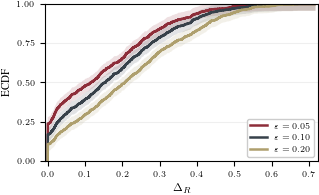

In [10]:
def ecdf(values: np.ndarray):
    x = np.sort(values)
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

def dkw_epsilon(n: int, alpha: float = 0.05) -> float:
    return np.sqrt(np.log(2.0 / alpha) / (2.0 * n))

ETA_FIXED = 0.5
ALPHA = 0.05
EPS_ORDER = None

df_eta = all_eval[all_eval["eta"] == ETA_FIXED].copy()
eps_vals = sorted(df_eta["eps"].unique()) if EPS_ORDER is None else EPS_ORDER

with plt.rc_context(bundles.icml2024(column="half")):
    plt.rcParams.update({"axes.prop_cycle": plt.cycler(color=palettes.tue_plot)})

    fig, ax = plt.subplots()

    for eps in eps_vals:
        vals = df_eta.loc[df_eta["eps"] == eps, "delta_R"].dropna().to_numpy()
        n = vals.size
        if n == 0:
            continue

        x, y = ecdf(vals)

        eps_band = dkw_epsilon(n, alpha=ALPHA)
        y_lo = np.clip(y - eps_band, 0.0, 1.0)
        y_hi = np.clip(y + eps_band, 0.0, 1.0)

        ax.fill_between(x, y_lo, y_hi, step="post", alpha=0.15, linewidth=0)
        ax.step(x, y, where="post", linewidth=1.8, label=rf"$\varepsilon={eps:.2f}$")

    ax.set_xlabel(r"$\Delta_R$")
    ax.set_ylabel("ECDF")

    ax.set_ylim(0, 1)
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])

    ax.grid(True, axis="y", alpha=0.2)
    ax.grid(False, axis="x")
    ax.margins(x=0.01)

    ax.legend(loc="lower right", frameon=True, framealpha=1.0, facecolor="white")

    fig.savefig("../report/figs/ecdf.pdf")
    plt.show()
